Considering the column_diagnosis.arff dataset available at the course webpage’s homework tab.
Using sklearn, apply a 10-fold stratified cross-validation with shuffling (random_state=0) for the
assessment of predictive models along this section.

In [2]:
import pandas as pd
from scipy.io.arff import loadarff

data = loadarff('data/column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')

X, y = df.drop('class', axis=1), df['class']


1) Compare the performance of 𝑘NN with 𝑘 = 5 and naïve Bayes with Gaussian assumption
(consider all remaining parameters for each classifier as sklearn’s default):

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

classifiers = [
    ("Gaussian Naive Bayes", GaussianNB()),
    ("kNN", KNeighborsClassifier(n_neighbors=5))
]

a. Plot two boxplots with the folds accuracies for each classifier.

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

knn_accs, nb_accs = [], []
knn_predictor = KNeighborsClassifier(n_neighbors=5)
nb_predictor = GaussianNB()

for train_k, test_k in folds.split(X, y):
    X_train, X_test = X.iloc[train_k], X.iloc[test_k]
    y_train, y_test = y.iloc[train_k], y.iloc[test_k]

    knn_predictor.fit(X_train, y_train)
    nb_predictor.fit(X_train, y_train)

    knn_pred = knn_predictor.predict(X_test)
    nb_pred = nb_predictor.predict(X_test)

    knn_accs.append(round(metrics.accuracy_score(y_test, knn_pred), 2))
    nb_accs.append(round(metrics.accuracy_score(y_test, nb_pred), 2))

print(knn_accs)
print(nb_accs)

[0.94, 0.81, 0.87, 0.94, 0.74, 0.87, 0.84, 0.84, 0.77, 0.77]
[0.84, 0.87, 0.84, 0.87, 0.77, 0.84, 0.9, 0.81, 0.77, 0.71]


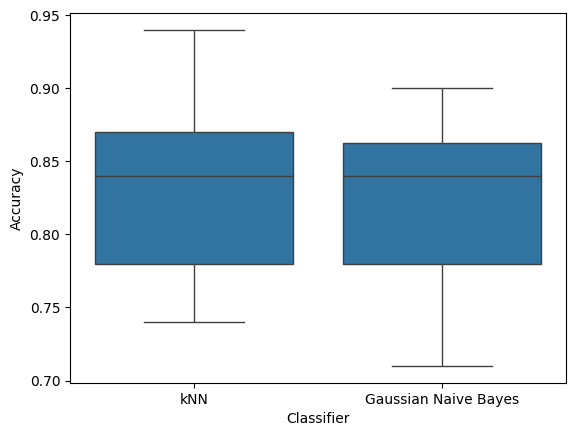

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fold_accs_join = []

fold_accs_join.extend(list(zip(["kNN" for i in range(10)], knn_accs)))
fold_accs_join.extend(list(zip(["Gaussian Naive Bayes" for i in range(10)], nb_accs)))

fold_accs_df = pd.DataFrame(fold_accs_join, columns=['Classifier', 'Accuracy'])

sns.boxplot(x='Classifier', y='Accuracy', data=fold_accs_df)
plt.show()

b. Using scipy, test the hypothesis “𝑘NN is statistically superior to naïve Bayes regarding
accuracy”, asserting whether is true.

In [6]:
from scipy import stats

res = stats.ttest_rel(knn_accs, nb_accs, alternative='greater')
print('h0: acc(kNN) = acc(NB) \nh1: acc(kNN) > acc(NB)\npvalue=', res.pvalue)

h0: acc(kNN) = acc(NB) 
h1: acc(kNN) > acc(NB)
pvalue= 0.1734666237861796


Visto que o p-value é aproximadamente 0.17, não podemos rejeitar a hipótese nula para os valores de significância usuais (geralmente igual ou inferior a 0.05), a favor da hipótese "kNN is statistically superior to naïve Bayes regarding accuracy".

2) Consider two 𝑘NN predictors with 𝑘=1 and 𝑘=5 (uniform weights, Euclidean distance, all remaining parameters as default). Plot the differences between the two cumulative confusion matrices of the predictors. Comment.

In [10]:
from sklearn import metrics
import numpy as np

confusion_matrix_knn1 = np.array([[0,0,0], [0,0,0], [0,0,0]])
confusion_matrix_knn5 = np.array([[0,0,0], [0,0,0], [0,0,0]])

for train_k, test_k in folds.split(X, y):
    X_train, X_test = X.iloc[train_k], X.iloc[test_k]
    y_train, y_test = y.iloc[train_k], y.iloc[test_k]

    knn_1 = KNeighborsClassifier(n_neighbors=1)
    knn_5 = KNeighborsClassifier(n_neighbors=5)

    knn_1.fit(X_train, y_train)
    knn_5.fit(X_train, y_train)

    y_knn1_pred = knn_1.predict(X_test)
    y_knn5_pred = knn_5.predict(X_test)

    confusion_matrix_knn1 = confusion_matrix_knn1 + \
        np.array(metrics.confusion_matrix(y_true=y_test, y_pred=y_knn1_pred, \
                                          labels=['Normal', 'Hernia', 'Spondylolisthesis']))
    confusion_matrix_knn5 = confusion_matrix_knn5 + \
        np.array(metrics.confusion_matrix(y_true=y_test, y_pred=y_knn5_pred, \
                                          labels=['Normal', 'Hernia', 'Spondylolisthesis']))

confusion_matrix_diff = confusion_matrix_knn1-confusion_matrix_knn5
confusion_matrix_diff = pd.DataFrame(confusion_matrix_diff, \
                                    index = ['Normal', 'Hernia', 'Spondylolisthesis'], \
                                    columns = ['Predicted Normal', 'Predicted Hernia', 'Predicted Spondylolisthesis'])
print("kNN cumulative confusion matrix subtraction:")
confusion_matrix_diff


kNN cumulative confusion matrix subtraction:


,Predicted Normal,Predicted Hernia,Predicted Spondylolisthesis
Normal,2,-5,3
Hernia,2,-2,0
Spondylolisthesis,1,0,-1


Ao fazemos a substração das matrizes de confusão cumulativas para o classificador kNN de k=1 com o classificador kNN de k=5, conseguimos concluir que valores negativos na substração indicam um maior número nessa célula a favor do classificador kNN de k=5, e se for positivo, a favor de kNN de k=1.

Ao observarmos as colunas, conseguimos concluir que o classificador de k=1 tem a tendência de classificar mais casos como "Normal" e que o classificador k=5 tem a tendência de classificar mais casos como "Hernia". Esta tendências podem ser observadas pela errada classifcação de mais 5 casos com "Hernia" enquanto na realidade era "Normal" pelo classificador k=5, enquanto que o classificador k=1 classificou erradamente como "Normal" duas observações "Hernia" e 1 observação "Spondylolisthesis". Curiosamente, ambos os modelos classificaram o mesmo número de casos reais de "Spondylolisthesis" como "Hernia".

No caso da classe "Spondylolisthesis" os classificadores possuem uma tendência semelhante ao classificar observações para esta classe enquanto se trata de uma "Hernia". Por outro lado, o classificador k=1 preveu mais 3 observações com esta classe que eram "Normal" do que o classificador k=5, enquanto que o classificador k=5 classificou corretamente uma observação a mais do que k=1 para esta classe.

Para classificações corretas (True Positives), o classificador k=5 classifica mais observações corretamente que se tratam de "Hernia" e "Spondylolisthesis", enquanto que k=1 classifica corretamente mais observações do tipo "Normal".

3) Considering the unique properties of column_diagnosis, identify three possible difficulties of naïve Bayes when learning from the given dataset.

Ao utilizarmos naïve Bayes, estamos a assumir independência entre as variáveis de input, o que poderá causar perda de informação se existir dependências entre elas. Neste caso, para um diagnóstico de coluna, geralmente é necessário considerar vários pontos (variáveis de input) relacionados, para se poder classificar corretamente, ou seja, neste caso perde-se informção ao usar este modelo. Este facto, junto com a assumção gaussiana, faz com que haja perda de informação, visto que o mais correto seria considerar as variáveis de imput como uma gaussiana multivariada.

Para além disso, para utilizar este modelo, apenas usámos uma amostra de 310 observações, ou seja um número limitado de observações da população inteira, o que pode gerar resultados não descritivos da população que estamos a estudar, ainda por cima considerando a dimensionalidade do conjunto de dados.

Para estes dados, também falta balançeamento de classes, visto que existe 150 observações de "Spondylolisthesis", 100 observações de "Normal" e 60 observações de "Hernia" (obtidos através da função `df.value_counts("class")`). Ou seja, visto que o `sklearn.naive_bayes` utiliza um critério MAP, é criado bias através dos priors.

In [8]:
print(df.value_counts("class"))

class
Spondylolisthesis    150
Normal               100
Hernia                60
Name: count, dtype: int64
